In [1]:
import math
import statistics
import timeit

import matplotlib.pyplot as plt
import networkx as nx
import pandas as pd
from rdkit import Chem, DataStructs
from rdkit.Chem import AllChem
import seaborn as sns
sns.set_theme(rc={"figure.dpi": 500})

from gesim import gesim

In [2]:
df_id_smi = pd.read_csv('data/zinc20_1k_random_sample.smi', delimiter=' ',header=None)
df_id_smi['mol'] = df_id_smi[1].apply(lambda x: Chem.MolFromSmiles(x))
zinc_mols = df_id_smi['mol'].tolist()

In [3]:
def calculate_batch_mfp_tanimoto_sim(mols):
    ref_mol = mols[0]
    for m in mols:
        ref_fp = AllChem.GetMorganFingerprintAsBitVect(ref_mol, radius=2, nBits=2048)
        fp = AllChem.GetMorganFingerprintAsBitVect(m, radius=2, nBits=2048)
        _ = DataStructs.TanimotoSimilarity(ref_fp, fp)


def calculate_batch_mfp_tanimoto_sim_from_fps(fps):
    ref_fp = fps[0]
    for fp in fps:
        _ = DataStructs.TanimotoSimilarity(ref_fp, fp)


def calculate_batch_gesim(mols):
    ref_mol = mols[0]
    for m in mols:
        _ = gesim.graph_entropy_similarity(ref_mol, m, r=4, use_logistic_scaler=False)
        

def calculate_ged(g1, g2):
    return nx.graph_edit_distance(g1, g2, edge_match=lambda a, b: a['weight'] == b['weight'], timeout=0.1)


def get_graph(mol):
    Chem.Kekulize(mol)
    atoms = [atom.GetAtomicNum() for atom in mol.GetAtoms()]
    am = Chem.GetAdjacencyMatrix(mol, useBO=True)
    for i, atom in enumerate(atoms):
        am[i, i] = atom
    G = nx.from_numpy_array(am)
    return G


def calculate_batch_ged(mols):
    ref_mol = mols[0]

    for m in mols:
        g1 = get_graph(ref_mol)
        g2 = get_graph(m)
        _ = calculate_ged(g1, g2)

In [15]:
calc_times_mfp = timeit.repeat(lambda: calculate_batch_mfp_tanimoto_sim(zinc_mols), repeat=10, number=1)
print(f"mean: {statistics.mean(calc_times_mfp): .03f} sec, std: {statistics.stdev(calc_times_mfp): .03f} sec")

mean:  0.116 sec, std:  0.001 sec


In [16]:
zinc_fps = [AllChem.GetMorganFingerprintAsBitVect(m, radius=2, nBits=2048) for m in zinc_mols]
calc_times_mfp_from_fps = timeit.repeat(lambda: calculate_batch_mfp_tanimoto_sim_from_fps(zinc_fps), repeat=10, number=1)
print(f"mean: {statistics.mean(calc_times_mfp_from_fps): .03f} sec, std: {statistics.stdev(calc_times_mfp_from_fps): .03f} sec")

mean:  0.002 sec, std:  0.000 sec


In [17]:
calc_times_gesim = timeit.repeat(lambda: calculate_batch_gesim(zinc_mols), repeat=10, number=1)
print(f"mean: {statistics.mean(calc_times_gesim): .03f} sec, std: {statistics.stdev(calc_times_gesim): .03f} sec")

mean:  1.098 sec, std:  0.005 sec


In [18]:
calc_times_ged = timeit.repeat(lambda: calculate_batch_ged(zinc_mols), repeat=10, number=1)
print(f"mean: {statistics.mean(calc_times_ged): .03f} sec, std: {statistics.stdev(calc_times_ged): .03f} sec")

mean:  103.404 sec, std:  0.017 sec


In [19]:
df = pd.DataFrame(
    {"Time": [math.log10(t * 1000) for t in calc_times_gesim + calc_times_mfp + calc_times_mfp_from_fps + calc_times_ged],  # sec -> milli sec
    "Method": ["GESim\n(Mol → Sim.)"]*10 + ["ECFP\n(Mol → Sim.)"]*10 + ["ECFP\n(FP → Sim.)"]*10 + ["GED\n(Mol → Sim.)"]*10}
)

Cumulative Timeout Limit (0.1 sec per each attempt): 5.0


/tmp/ipykernel_3519247/1871569926.py:8: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), fontsize=24)
/tmp/ipykernel_3519247/1871569926.py:9: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(ax.get_yticklabels(), fontsize=18)


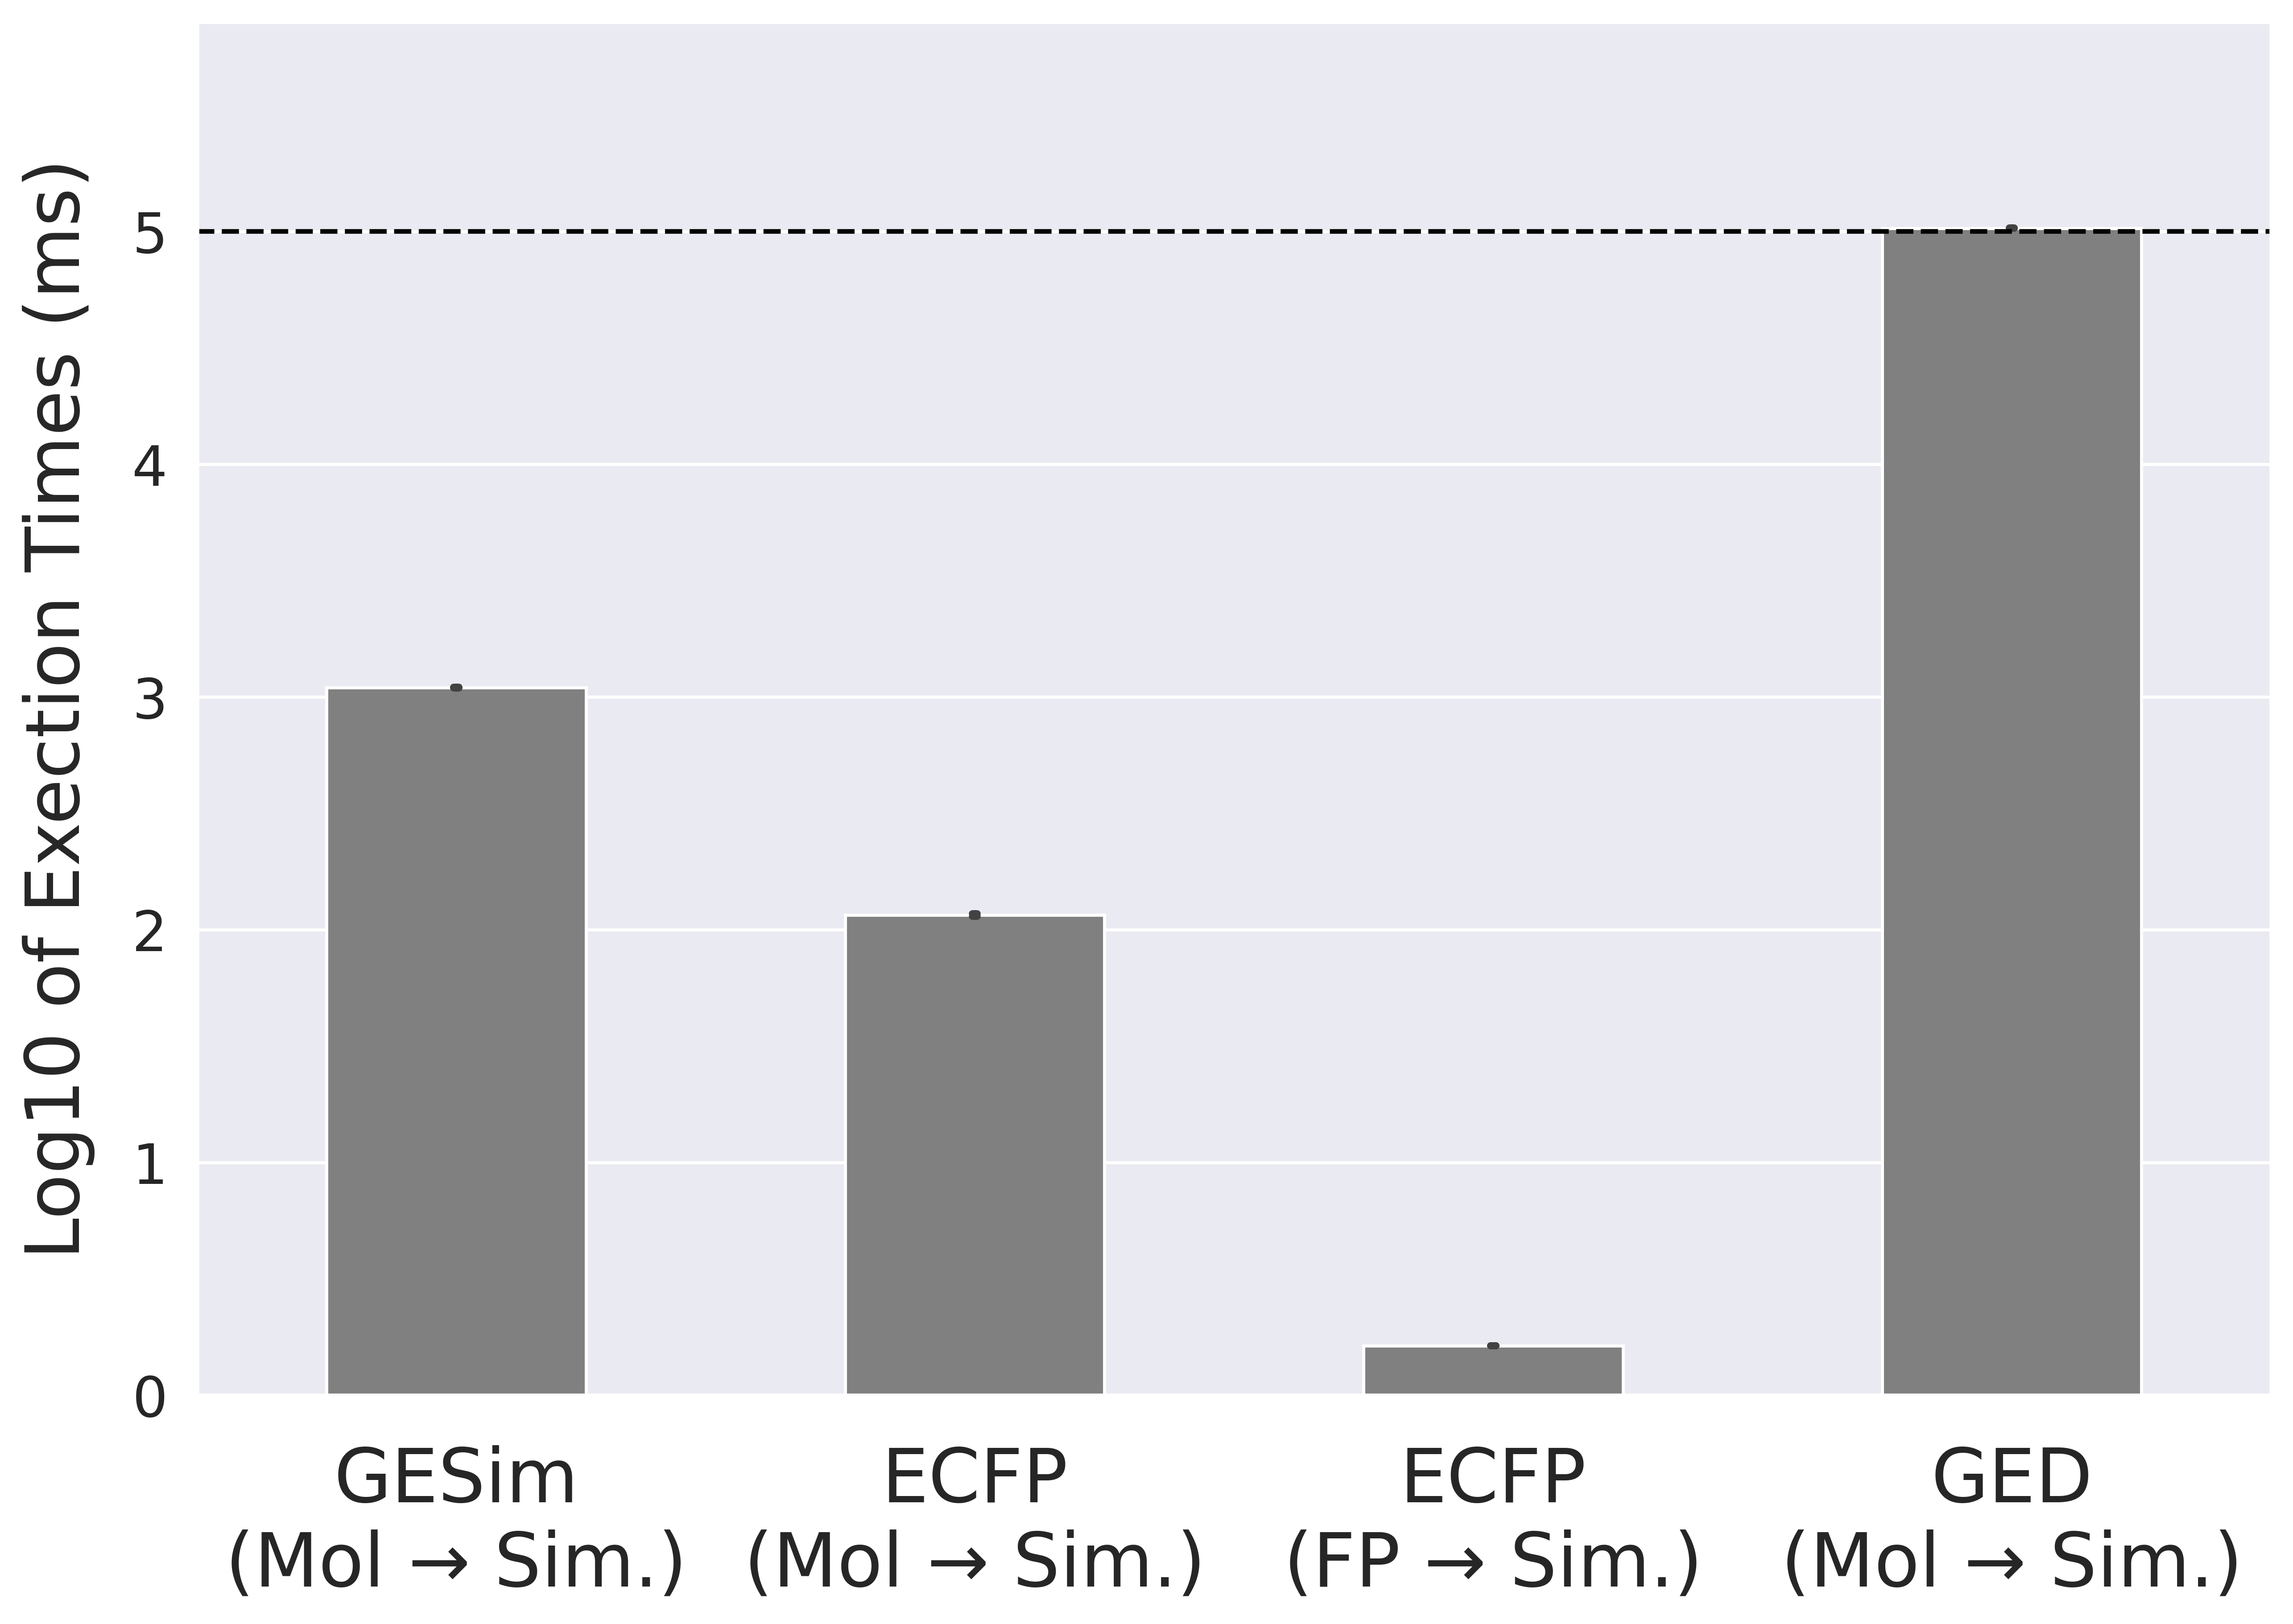

In [20]:
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(1, 1, 1)
ax = sns.barplot(df, x="Method", y="Time", ax=ax, color='grey', errorbar='sd', width=0.5, capsize=0.01)
print(f"Cumulative Timeout Limit (0.1 sec per each attempt): {math.log10(100 * 1000)}")
ax.axhline(y=5, color='black', linestyle='--')
ax.set_ylim(0.0, 5.9)

ax.set_xticklabels(ax.get_xticklabels(), fontsize=24)
ax.set_yticklabels(ax.get_yticklabels(), fontsize=18)
ax.set_xlabel("")
ax.set_ylabel("Log10 of Exection Times (ms)", fontsize=24, labelpad=12)
ax.tick_params(axis='x', which='major', pad=10)